This code is based on the basic regression TensorFlow tutorial, available online (https://www.tensorflow.org/tutorials/keras/regression)

Requires tensorflow_docs (to plot training history). 
To install it run:

```!pip install -q git+https://github.com/tensorflow/docs```

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import datetime

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

import os 
import sys
sys.path.append(os.path.abspath('../utils'))
from load_lib import *

# Load and prepare dataset

## Loading utilities

In [3]:
def flatten_H4_geometry(geometry):
    positions = np.array(list(zip(*geometry))[1]) # discard the atom names
    return [positions[i][j] for i in range(1, 4) for j in range(0, i)]

def extract_input_output(dataset):
    '''
    Given a list of data dictionaries, Returns np.arrays (input, output).
        input element: flattened (geometry + orbital_energy)
        output element: exact_energy
    '''
    return map(np.array, list(zip(*(
        (flatten_H4_geometry(d['geometry']) + d['orbital_energies'].tolist(),
         d['exact_energy'])
        for d in dataset))))

def split_train_test(dataset, training_fraction=0.8):
    rng = np.random.default_rng()
    shuffled_set = rng.permutation(dataset)
    train_set = shuffled_set[:int(training_fraction*len(dataset))]
    test_set = shuffled_set[int(training_fraction*len(dataset)):]
    
    return train_set, test_set

## load data from file 

In [4]:
files = os.listdir(JSON_DIR)
dataset = [load_data(JSON_DIR + file) for file in files]

## split in training and test set, input and output

In [5]:
train_set, test_set = split_train_test(dataset)

In [6]:
train_input, train_output = extract_input_output(train_set)
test_input, test_output = extract_input_output(test_set)

## Normalize input to facilitate training

In [7]:
means = np.mean(train_input, axis=0)
stds = np.std(train_input, axis=0)
def normalize_input(x):
    return (x - means) / stds
train_norm_input = normalize_input(train_input)
test_norm_input = normalize_input(test_input)

# Utilities & functions

## ML model 

In [8]:
def build_model(layer_size = 8, depth = 2):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(layer_size, activation='relu',
                              input_shape=[len(train_norm_input[0])])
    ] + [
        tf.keras.layers.Dense(layer_size, activation='relu')
        for _ in range(depth - 1)
    ] + [
        tf.keras.layers.Dense(1)
    ])

    #optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      0.05,
      decay_steps=len(train_output)*10,
      decay_rate=1,
      staircase=False)
    optimizer = tf.keras.optimizers.Adam(lr_schedule)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

## training utilities 

In [35]:
def naive_training(model, max_epochs=500, plot=True):
    history = model.fit(
      train_norm_input, train_output,
      epochs=max_epochs, validation_split = 0.2, verbose=0,
      callbacks=[tfdocs.modeling.EpochDots(report_every=100)])

    if plot:
        plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
        plotter.plot({'Basic': history}, metric = "mse")
        plt.ylim(0, max(0.1, history.history['mse'][10]))
        plt.ylabel('MSE')
        plt.show()
    
def early_stop_training(model, max_epochs=500, patience = 30,
                        plot=True,
                        additional_callbacks = []):
    # The patience parameter is the amount of epochs to check for improvement
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  patience=patience)

    callbacks = ([early_stop] + 
                 ([tfdocs.modeling.EpochDots(report_every=100)] 
                  if plot else []) + 
                 additional_callbacks
                )
    
    early_history = model.fit(train_norm_input, train_output, 
                        epochs=max_epochs, validation_split = 0.2, verbose=0, 
                        callbacks=callbacks)
    
    if plot:
        plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
        plotter.plot({'Early Stopping': early_history}, metric = "mse")
        plt.ylim([0, 0.1])
        plt.ylabel('MSE')
        plt.show()

## Benchmark utilities

In [10]:
test_hfe = [d['hf_energy'] for d in test_set]

def print_test_metrics(model):
    loss, mae, mse = model.evaluate(test_norm_input, test_output, verbose=2)

    print(f"Test set Root Mean Square Error: {np.sqrt(mse):.2f} Ha")

    hf_rms = np.sqrt(np.sum((test_hfe - test_output)**2)/len(test_output))
    print(f"Hartree-Fock Root Mean Square Error: {hf_rms:.2f} Ha")
    print()
    
def plot_predictions_benchmark(model):
    test_predictions = model.predict(test_norm_input).flatten()

    a = plt.axes(aspect='equal')
    plt.scatter(test_output, test_predictions, label = 'Predicted by NN')
    plt.scatter(test_output, test_hfe, label = 'HF energy', marker='x')
    plt.xlabel('True GS energies (FCI) [Ha]')
    plt.ylabel('Energy by classical method [Ha]')
    #lims = [-2.25, -0.75]
    lims = plt.gca().get_ylim()
    plt.xlim(lims)
    plt.ylim(lims)
    plt.plot(lims, lims)
    plt.legend()
    plt.show()

def benchmark_model(model):
    print_test_metrics(model)
    plot_predictions_benchmark(model)

# Basic model and training details

## Model summary

In [11]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 88        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________


### untrained example

***** Example batch *****
model output, true energy
    -1.059      -1.797
    -0.206      -1.728
    -1.456      -1.879
    -0.615      -1.981
    -0.756      -1.671
    -2.192      -1.904
    -0.505      -1.759
    -0.601      -1.438
    -0.202      -1.708
    -0.438      -1.492

4/4 - 0s - loss: 1.0686 - mae: 0.9005 - mse: 1.0686
Test set Root Mean Square Error: 1.03 Ha
Hartree-Fock Root Mean Square Error: 0.07 Ha



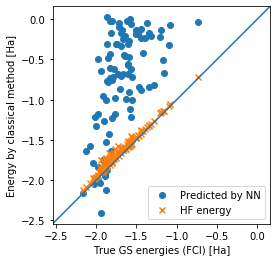

In [15]:
example_size = 10
example_batch = train_norm_input[:example_size]
example_result = model.predict(example_batch)
print('***** Example batch *****')
print('model output, true energy')
for model_output, true_energy in zip(example_result.flatten().tolist(), 
                                     train_output[:example_size]):
    print(f'{model_output:10.3f}  {true_energy:10.3f}')

print()

benchmark_model(model)

## naive training 


Epoch: 0, loss:0.5063,  mae:0.5544,  mse:0.5063,  val_loss:0.1139,  val_mae:0.2545,  val_mse:0.1139,  
....................................................................................................
Epoch: 100, loss:0.0034,  mae:0.0458,  mse:0.0034,  val_loss:0.0064,  val_mae:0.0613,  val_mse:0.0064,  
....................................................................................................
Epoch: 200, loss:0.0035,  mae:0.0468,  mse:0.0035,  val_loss:0.0053,  val_mae:0.0578,  val_mse:0.0053,  
....................................................................................................
Epoch: 300, loss:0.0020,  mae:0.0348,  mse:0.0020,  val_loss:0.0042,  val_mae:0.0514,  val_mse:0.0042,  
....................................................................................................
Epoch: 400, loss:0.0024,  mae:0.0384,  mse:0.0024,  val_loss:0.0054,  val_mae:0.0592,  val_mse:0.0054,  
........................................................................

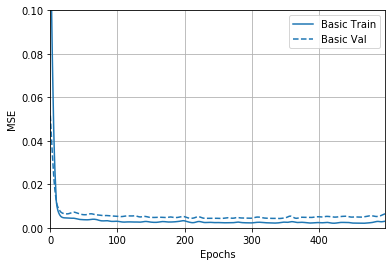

In [16]:
model = build_model()
naive_training(model)

4/4 - 0s - loss: 0.0080 - mae: 0.0712 - mse: 0.0080
Test set Root Mean Square Error: 0.09 Ha
Hartree-Fock Root Mean Square Error: 0.07 Ha



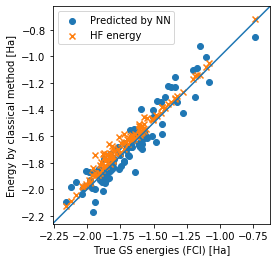

In [17]:
benchmark_model(model)

## using EarlyStopping to avoid overfitting


Epoch: 0, loss:0.9338,  mae:0.7300,  mse:0.9338,  val_loss:0.2132,  val_mae:0.4011,  val_mse:0.2132,  
.......................................................................................

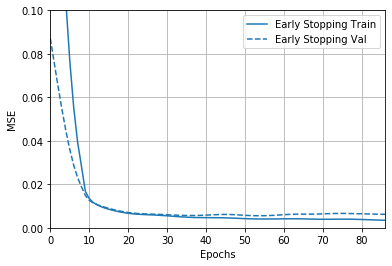

4/4 - 0s - loss: 0.0056 - mae: 0.0586 - mse: 0.0056
Test set Root Mean Square Error: 0.07 Ha
Hartree-Fock Root Mean Square Error: 0.07 Ha



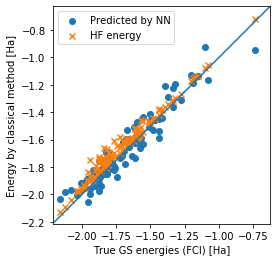

In [19]:
model = build_model()
early_stop_training(model)
benchmark_model(model)

### conclusions:
early stopping is not giving fundamental improvements, but it's a good way to shorten training. 
We will make use of it from here on.

# Test different layer sizes 

## visualize


Epoch: 0, loss:1.3378,  mae:1.0167,  mse:1.3378,  val_loss:0.4807,  val_mae:0.5647,  val_mse:0.4807,  
.........................................................................

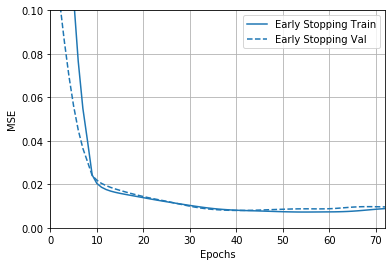

4/4 - 0s - loss: 0.0075 - mae: 0.0666 - mse: 0.0075
Test set Root Mean Square Error: 0.09 Ha
Hartree-Fock Root Mean Square Error: 0.05 Ha



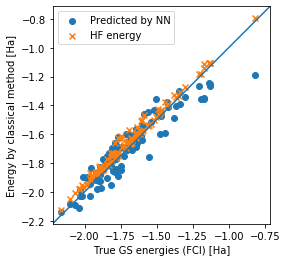

In [100]:
model = build_model(layer_size = 4)
early_stop_training(model)
benchmark_model(model)


Epoch: 0, loss:1.1122,  mae:0.8162,  mse:1.1122,  val_loss:0.1400,  val_mae:0.3122,  val_mse:0.1400,  
.................................................................................

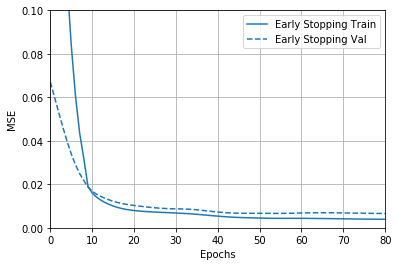

4/4 - 0s - loss: 0.0071 - mae: 0.0650 - mse: 0.0071
Test set Root Mean Square Error: 0.08 Ha
Hartree-Fock Root Mean Square Error: 0.05 Ha



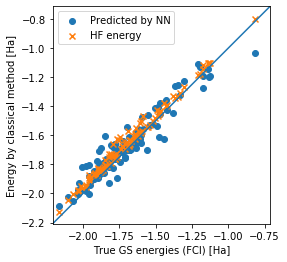

In [101]:
model = build_model(layer_size = 8)
early_stop_training(model)
benchmark_model(model)


Epoch: 0, loss:0.5927,  mae:0.6057,  mse:0.5927,  val_loss:0.1927,  val_mae:0.3616,  val_mse:0.1927,  
....................................................................................................
Epoch: 100, loss:0.0016,  mae:0.0306,  mse:0.0016,  val_loss:0.0055,  val_mae:0.0593,  val_mse:0.0055,  
................................................................................

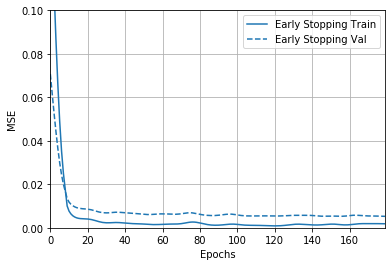

4/4 - 0s - loss: 0.0038 - mae: 0.0498 - mse: 0.0038
Test set Root Mean Square Error: 0.06 Ha
Hartree-Fock Root Mean Square Error: 0.05 Ha



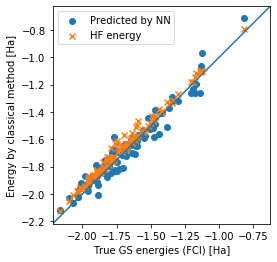

In [102]:
model = build_model(layer_size = 16)
early_stop_training(model)
benchmark_model(model)


Epoch: 0, loss:1.2001,  mae:0.8629,  mse:1.2001,  val_loss:0.2343,  val_mae:0.4189,  val_mse:0.2343,  
.......................................................................

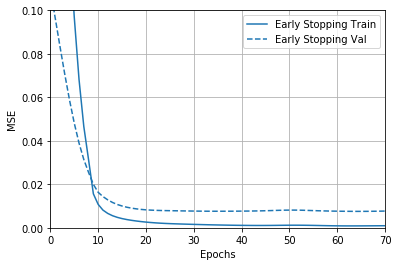

4/4 - 0s - loss: 0.0054 - mae: 0.0564 - mse: 0.0054
Test set Root Mean Square Error: 0.07 Ha
Hartree-Fock Root Mean Square Error: 0.05 Ha



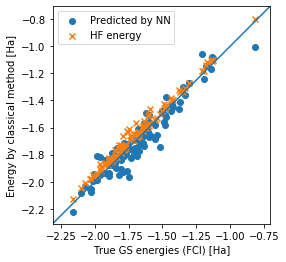

In [103]:
model = build_model(layer_size = 32)
early_stop_training(model)
benchmark_model(model)

## systematic test

In [229]:
size_list = [2, 4, 6, 8, 10, 14, 16, 20, 32, 44, 64]
n_samples = 15

mse_s_lists = []
for size in size_list:
    mse_s_lists.append([])
    for _ in range(n_samples):
        model = build_model(size)
        early_stop_training(model, plot=False)
        loss, mae, mse = model.evaluate(test_norm_input, test_output, verbose=2)
        mse_s_lists[-1].append(mse)

4/4 - 0s - loss: 0.0053 - mae: 0.0596 - mse: 0.0053
4/4 - 0s - loss: 0.0048 - mae: 0.0563 - mse: 0.0048
4/4 - 0s - loss: 0.0073 - mae: 0.0639 - mse: 0.0073
4/4 - 0s - loss: 0.0046 - mae: 0.0539 - mse: 0.0046
4/4 - 0s - loss: 0.0064 - mae: 0.0631 - mse: 0.0064
4/4 - 0s - loss: 0.0102 - mae: 0.0852 - mse: 0.0102
4/4 - 0s - loss: 0.0070 - mae: 0.0658 - mse: 0.0070
4/4 - 0s - loss: 0.0089 - mae: 0.0782 - mse: 0.0089
4/4 - 0s - loss: 0.0064 - mae: 0.0595 - mse: 0.0064
4/4 - 0s - loss: 0.0057 - mae: 0.0569 - mse: 0.0057
4/4 - 0s - loss: 0.0623 - mae: 0.1936 - mse: 0.0623
4/4 - 0s - loss: 0.0067 - mae: 0.0584 - mse: 0.0067
4/4 - 0s - loss: 0.0073 - mae: 0.0667 - mse: 0.0073
4/4 - 0s - loss: 0.0065 - mae: 0.0598 - mse: 0.0065
4/4 - 0s - loss: 0.0624 - mae: 0.1959 - mse: 0.0624
4/4 - 0s - loss: 0.0049 - mae: 0.0558 - mse: 0.0049
4/4 - 0s - loss: 0.0623 - mae: 0.1947 - mse: 0.0623
4/4 - 0s - loss: 0.0082 - mae: 0.0728 - mse: 0.0082
4/4 - 0s - loss: 0.0063 - mae: 0.0656 - mse: 0.0063
4/4 - 0s - l

4/4 - 0s - loss: 0.0049 - mae: 0.0564 - mse: 0.0049
4/4 - 0s - loss: 0.0053 - mae: 0.0581 - mse: 0.0053
4/4 - 0s - loss: 0.0076 - mae: 0.0655 - mse: 0.0076
4/4 - 0s - loss: 0.0045 - mae: 0.0514 - mse: 0.0045
4/4 - 0s - loss: 0.0073 - mae: 0.0645 - mse: 0.0073
4/4 - 0s - loss: 0.0054 - mae: 0.0601 - mse: 0.0054
4/4 - 0s - loss: 0.0047 - mae: 0.0534 - mse: 0.0047


(0, 0.01)

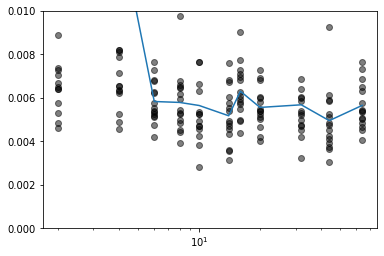

In [231]:
plt.plot(size_list, mse_s_lists, 'ok', alpha=0.5)
plt.plot(size_list, np.mean(mse_s_lists, axis=1))
plt.xscale('log')
plt.ylim(0,.01)

### conclusion:
It seems all sizes larger than 6 do a decent job. 
We'll later use 8 or 16 to keep the NN small without sacrificing on the representative power

# Try dropout

In [20]:
def build_model_wdropout(layer_size = 16, dropout = 0):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(layer_size, activation='relu', 
                              input_shape=[len(train_norm_input[0])])
    ] + ([tf.keras.layers.Dropout(dropout)] if dropout!=0 else []) + [
        tf.keras.layers.Dense(layer_size, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    #optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      0.05,
      decay_steps=len(train_output)*10,
      decay_rate=1,
      staircase=False)
    optimizer = tf.keras.optimizers.Adam(lr_schedule)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

## with dropout 


Epoch: 0, loss:0.7890,  mae:0.7177,  mse:0.7890,  val_loss:0.4022,  val_mae:0.5391,  val_mse:0.4022,  
....................................................................................................
Epoch: 100, loss:0.0064,  mae:0.0621,  mse:0.0064,  val_loss:0.0063,  val_mae:0.0628,  val_mse:0.0063,  
....................................................................................................
Epoch: 200, loss:0.0072,  mae:0.0631,  mse:0.0072,  val_loss:0.0066,  val_mae:0.0679,  val_mse:0.0066,  
....................................................................................................
Epoch: 300, loss:0.0046,  mae:0.0501,  mse:0.0046,  val_loss:0.0078,  val_mae:0.0755,  val_mse:0.0078,  
....................................................................................................
Epoch: 400, loss:0.0060,  mae:0.0586,  mse:0.0060,  val_loss:0.0101,  val_mae:0.0857,  val_mse:0.0101,  
........................................................................

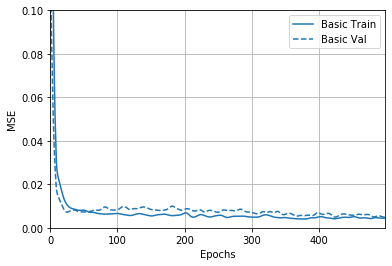


4/4 - 0s - loss: 0.0076 - mae: 0.0711 - mse: 0.0076
Test set Root Mean Square Error: 0.09 Ha
Hartree-Fock Root Mean Square Error: 0.07 Ha



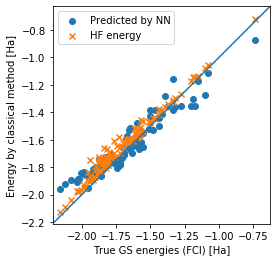

In [21]:
model = build_model_wdropout(layer_size=16, dropout=0.2)
naive_training(model)
print()
benchmark_model(model)

## without dropout 


Epoch: 0, loss:0.5214,  mae:0.5884,  mse:0.5214,  val_loss:0.3127,  val_mae:0.4335,  val_mse:0.3127,  
....................................................................................................
Epoch: 100, loss:0.0012,  mae:0.0281,  mse:0.0012,  val_loss:0.0047,  val_mae:0.0556,  val_mse:0.0047,  
....................................................................................................
Epoch: 200, loss:0.0011,  mae:0.0265,  mse:0.0011,  val_loss:0.0045,  val_mae:0.0541,  val_mse:0.0045,  
....................................................................................................
Epoch: 300, loss:0.0007,  mae:0.0213,  mse:0.0007,  val_loss:0.0034,  val_mae:0.0461,  val_mse:0.0034,  
....................................................................................................
Epoch: 400, loss:0.0007,  mae:0.0222,  mse:0.0007,  val_loss:0.0044,  val_mae:0.0545,  val_mse:0.0044,  
........................................................................

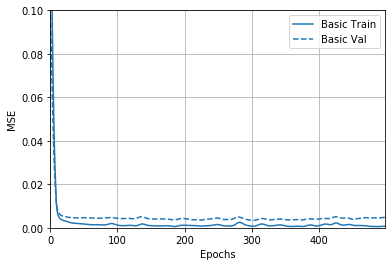


4/4 - 0s - loss: 0.0056 - mae: 0.0591 - mse: 0.0056
Test set Root Mean Square Error: 0.07 Ha
Hartree-Fock Root Mean Square Error: 0.07 Ha



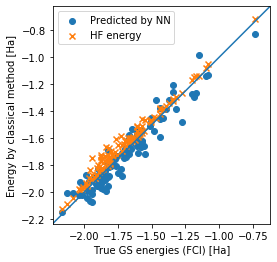

In [24]:
model = build_model_wdropout(layer_size=16, dropout = 0)
naive_training(model)
print()
benchmark_model(model)

## conclusions:
Dropout seems counterproductive

# Try weight regularization

In [25]:
def build_model_wreg(layer_size = 16, l = 0.001):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(layer_size, activation='relu', 
                              kernel_regularizer=tf.keras.regularizers.l2(l),
                              input_shape=[len(train_norm_input[0])]),
        tf.keras.layers.Dense(layer_size, activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l2(l)),
        tf.keras.layers.Dense(1)
    ])

    #optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      0.05,
      decay_steps=len(train_output)*10,
      decay_rate=1,
      staircase=False)
    optimizer = tf.keras.optimizers.Adam(lr_schedule)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

## with strong regularization


Epoch: 0, loss:2.8439,  mae:0.7941,  mse:0.9720,  val_loss:1.3104,  val_mae:0.5307,  val_mse:0.3466,  
....................................................................................................
Epoch: 100, loss:0.0219,  mae:0.0728,  mse:0.0101,  val_loss:0.0199,  val_mae:0.0707,  val_mse:0.0092,  
....................................................................................................
Epoch: 200, loss:0.0185,  mae:0.0697,  mse:0.0089,  val_loss:0.0184,  val_mae:0.0749,  val_mse:0.0087,  
....................................................................................................
Epoch: 300, loss:0.0211,  mae:0.0894,  mse:0.0129,  val_loss:0.0198,  val_mae:0.0865,  val_mse:0.0115,  
....................................................................................................
Epoch: 400, loss:0.0166,  mae:0.0716,  mse:0.0086,  val_loss:0.0174,  val_mae:0.0785,  val_mse:0.0101,  
........................................................................

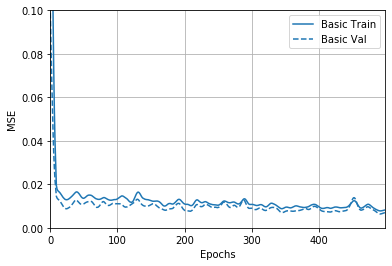


4/4 - 0s - loss: 0.0141 - mae: 0.0680 - mse: 0.0075
Test set Root Mean Square Error: 0.09 Ha
Hartree-Fock Root Mean Square Error: 0.07 Ha



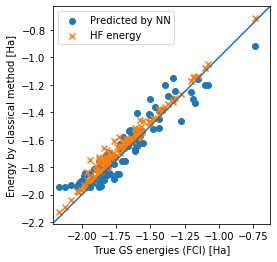

In [27]:
model = build_model_wreg(layer_size=16, l=0.1)
naive_training(model)
print()
benchmark_model(model)

## with medium regularization 


Epoch: 0, loss:0.4502,  mae:0.5006,  mse:0.4207,  val_loss:0.1797,  val_mae:0.2996,  val_mse:0.1479,  
....................................................................................................
Epoch: 100, loss:0.0070,  mae:0.0553,  mse:0.0054,  val_loss:0.0073,  val_mae:0.0607,  val_mse:0.0058,  
....................................................................................................
Epoch: 200, loss:0.0061,  mae:0.0506,  mse:0.0047,  val_loss:0.0058,  val_mae:0.0526,  val_mse:0.0043,  
....................................................................................................
Epoch: 300, loss:0.0067,  mae:0.0540,  mse:0.0053,  val_loss:0.0061,  val_mae:0.0548,  val_mse:0.0047,  
....................................................................................................
Epoch: 400, loss:0.0063,  mae:0.0519,  mse:0.0050,  val_loss:0.0056,  val_mae:0.0521,  val_mse:0.0044,  
........................................................................

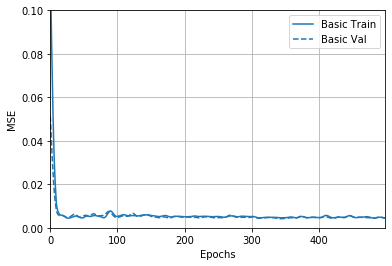


4/4 - 0s - loss: 0.0061 - mae: 0.0539 - mse: 0.0047
Test set Root Mean Square Error: 0.07 Ha
Hartree-Fock Root Mean Square Error: 0.07 Ha



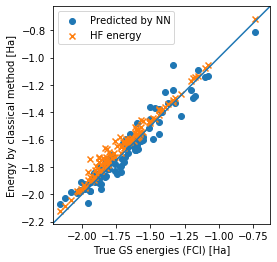

In [28]:
model = build_model_wreg(layer_size=16, l = 0.001)
naive_training(model)
print()
benchmark_model(model)

## with weak regularization


Epoch: 0, loss:1.0309,  mae:0.7626,  mse:1.0277,  val_loss:0.3721,  val_mae:0.5550,  val_mse:0.3686,  
....................................................................................................
Epoch: 100, loss:0.0035,  mae:0.0362,  mse:0.0021,  val_loss:0.0069,  val_mae:0.0559,  val_mse:0.0055,  
....................................................................................................
Epoch: 200, loss:0.0041,  mae:0.0463,  mse:0.0032,  val_loss:0.0053,  val_mae:0.0541,  val_mse:0.0044,  
....................................................................................................
Epoch: 300, loss:0.0031,  mae:0.0363,  mse:0.0023,  val_loss:0.0067,  val_mae:0.0636,  val_mse:0.0059,  
....................................................................................................
Epoch: 400, loss:0.0020,  mae:0.0269,  mse:0.0012,  val_loss:0.0044,  val_mae:0.0458,  val_mse:0.0036,  
........................................................................

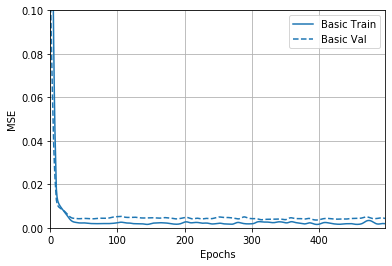


4/4 - 0s - loss: 0.0051 - mae: 0.0509 - mse: 0.0043
Test set Root Mean Square Error: 0.07 Ha
Hartree-Fock Root Mean Square Error: 0.07 Ha



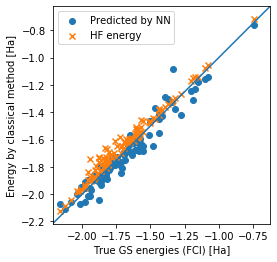

In [30]:
model = build_model_wreg(layer_size=16, l=0.0001)
naive_training(model)
print()
benchmark_model(model)

## conclusions:
Regularization does not show clear advantages.
We will not apply regularization, for simplicity.

# test deeper NNs

## visualize 


Epoch: 0, loss:1.0519,  mae:0.8266,  mse:1.0519,  val_loss:0.2197,  val_mae:0.3529,  val_mse:0.2197,  
........................................................................

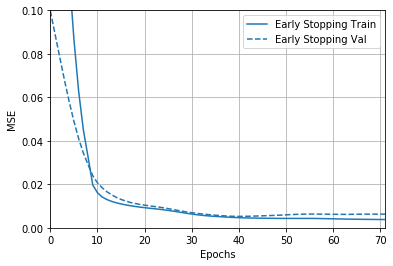

4/4 - 0s - loss: 0.0045 - mae: 0.0516 - mse: 0.0045
Test set Root Mean Square Error: 0.07 Ha
Hartree-Fock Root Mean Square Error: 0.05 Ha



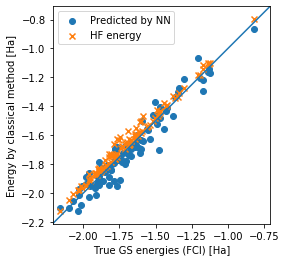

In [199]:
model = build_model(depth = 1)
early_stop_training(model)
benchmark_model(model)


Epoch: 0, loss:0.7863,  mae:0.7094,  mse:0.7863,  val_loss:0.2902,  val_mae:0.4664,  val_mse:0.2902,  
.................................................................

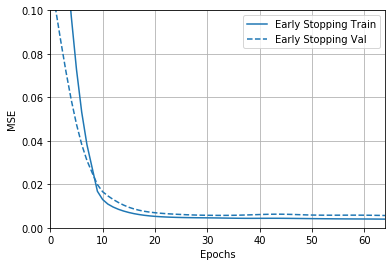

4/4 - 0s - loss: 0.0056 - mae: 0.0613 - mse: 0.0056
Test set Root Mean Square Error: 0.07 Ha
Hartree-Fock Root Mean Square Error: 0.05 Ha



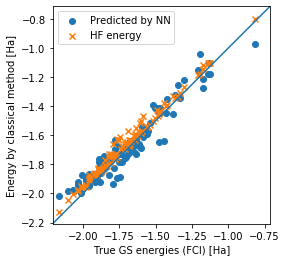

In [192]:
model = build_model(depth = 2)
early_stop_training(model)
benchmark_model(model)


Epoch: 0, loss:0.7461,  mae:0.6785,  mse:0.7461,  val_loss:0.1201,  val_mae:0.2902,  val_mse:0.1201,  
.......................................

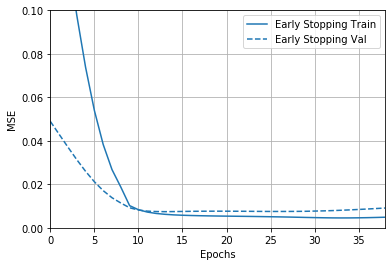

4/4 - 0s - loss: 0.0142 - mae: 0.0996 - mse: 0.0142
Test set Root Mean Square Error: 0.12 Ha
Hartree-Fock Root Mean Square Error: 0.05 Ha



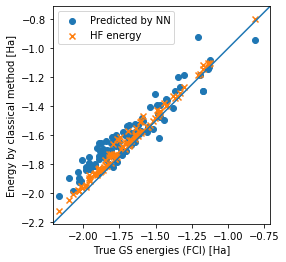

In [193]:
model = build_model(depth = 3)
early_stop_training(model)
benchmark_model(model)


Epoch: 0, loss:0.4567,  mae:0.5140,  mse:0.4567,  val_loss:0.0767,  val_mae:0.2115,  val_mse:0.0767,  
..............................................................................................

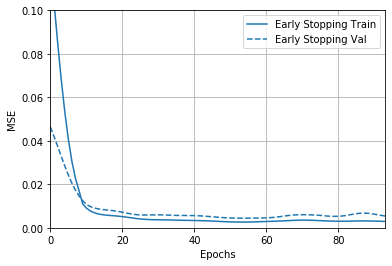

4/4 - 0s - loss: 0.0047 - mae: 0.0546 - mse: 0.0047
Test set Root Mean Square Error: 0.07 Ha
Hartree-Fock Root Mean Square Error: 0.05 Ha



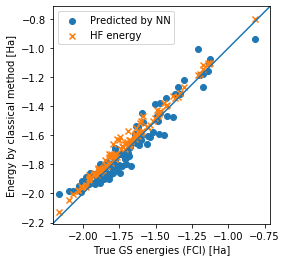

In [197]:
model = build_model(depth = 4)
early_stop_training(model)
benchmark_model(model)

## systematic test

In [224]:
depth_list = [1, 2, 3, 4, 5, 6]
n_samples = 10

mse_lists = []
for depth in depth_list:
    mse_lists.append([])
    for _ in range(n_samples):
        model = build_model(depth=depth)
        early_stop_training(model, plot=False)
        loss, mae, mse = model.evaluate(test_norm_input, test_output, verbose=0)
        mse_lists[-1].append(mse)
        print(',', sep='', end='', flush=True)

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

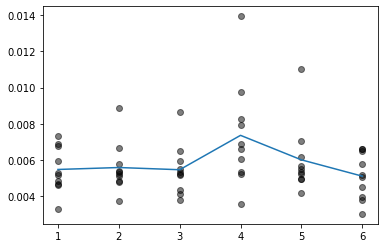

In [228]:
plt.plot(depth_list, mse_lists, 'ok', alpha=0.5)
plt.plot(depth_list, np.mean(mse_lists, axis=1))

### conclusions:
using deep networks does not seem to have any advantage.

# Test different losses

## MSE (as above)


Epoch: 0, loss:1.1401,  mae:0.7616,  mse:1.1401,  val_loss:0.1913,  val_mae:0.3623,  val_mse:0.1913,  
....................................................................................................
Epoch: 100, loss:0.0041,  mae:0.0502,  mse:0.0041,  val_loss:0.0063,  val_mae:0.0625,  val_mse:0.0063,  
..................................................................

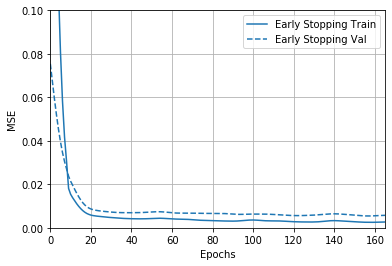

4/4 - 0s - loss: 0.0067 - mae: 0.0629 - mse: 0.0067
Test set Root Mean Square Error: 0.08 Ha
Hartree-Fock Root Mean Square Error: 0.06 Ha



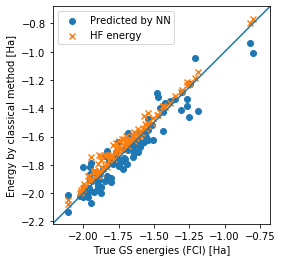

In [15]:
model = build_model()
early_stop_training(model)
benchmark_model(model)

## MAE

In [18]:
def build_model(layer_size = 8, depth = 2):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(layer_size, activation='relu',
                              input_shape=[len(train_norm_input[0])])
    ] + [
        tf.keras.layers.Dense(layer_size, activation='relu')
        for _ in range(depth - 1)
    ] + [
        tf.keras.layers.Dense(1)
    ])

    #optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      0.05,
      decay_steps=len(train_output)*10,
      decay_rate=1,
      staircase=False)
    optimizer = tf.keras.optimizers.Adam(lr_schedule)

    model.compile(loss='mae',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model


Epoch: 0, loss:0.7009,  mae:0.7009,  mse:0.8494,  val_loss:0.3559,  val_mae:0.3559,  val_mse:0.1733,  
....................................................................................................
Epoch: 100, loss:0.0588,  mae:0.0588,  mse:0.0061,  val_loss:0.0545,  val_mae:0.0545,  val_mse:0.0063,  
..............

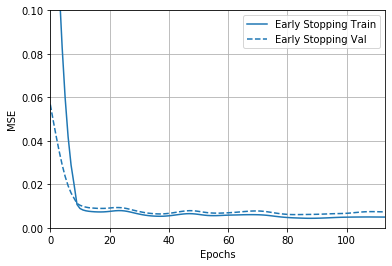

4/4 - 0s - loss: 0.0622 - mae: 0.0622 - mse: 0.0066
Test set Root Mean Square Error: 0.08 Ha
Hartree-Fock Root Mean Square Error: 0.06 Ha



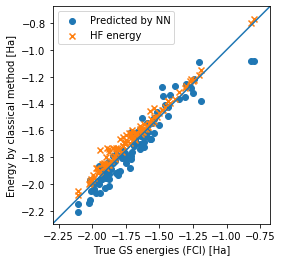

In [20]:
model = build_model()
early_stop_training(model)
benchmark_model(model)

## custom asymmetric loss 

One of the main advantages of using a variational method (e.g. Hartree-Fock, VQE) to estimate ground state energies, is that the final result's average will never be below the actual ground state energy.
I.E. a variational estimator of the ground state energy will never be negatively biased.

Note that statistical error (if present, i.e. finite sampling error in VQE), can cause a single-run estimation to be below GS energy. Nevertheless this kind of error can be arbitrarily reduced by taking more shots

To partly recover such behavior in our ML model, we implement here a asymmetric loss function, where predictions below the true GS energy are penalized more than the ones above.
We use
$$
    \mathrm{loss} = \alpha ( \delta - |\delta| ) + \delta^2
$$
with $\delta = E_\mathrm{predicted} - E_\mathrm{GS}$ and $\alpha$ a penalization constant

In [31]:
alpha = 1
def custom_loss(target, predicted):
    return tf.reduce_mean(
        alpha * (tf.abs(predicted - target) - (predicted - target))
        + tf.square(predicted - target) 
    )

def build_model(layer_size = 8, depth = 2):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(layer_size, activation='relu',
                              input_shape=[len(train_norm_input[0])])
    ] + [
        tf.keras.layers.Dense(layer_size, activation='relu')
        for _ in range(depth - 1)
    ] + [
        tf.keras.layers.Dense(1)
    ])

    #optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      0.05,
      decay_steps=len(train_output)*10,
      decay_rate=1,
      staircase=False)
    optimizer = tf.keras.optimizers.Adam(lr_schedule)

    model.compile(loss=custom_loss,
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model


Epoch: 0, loss:1.7755,  mae:1.1605,  mse:1.6478,  val_loss:0.7665,  val_mae:0.8466,  val_mse:0.7665,  
....................................................................................................
Epoch: 100, loss:0.0381,  mae:0.1581,  mse:0.0326,  val_loss:0.0396,  val_mae:0.1748,  val_mse:0.0376,  
....................................................................................................
Epoch: 200, loss:0.0361,  mae:0.1626,  mse:0.0321,  val_loss:0.0624,  val_mae:0.1260,  val_mse:0.0248,  
..................................................................

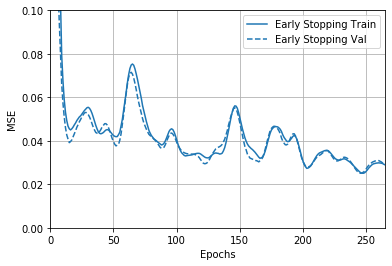

4/4 - 0s - loss: 0.0805 - mae: 0.1237 - mse: 0.0248
Test set Root Mean Square Error: 0.16 Ha
Hartree-Fock Root Mean Square Error: 0.07 Ha



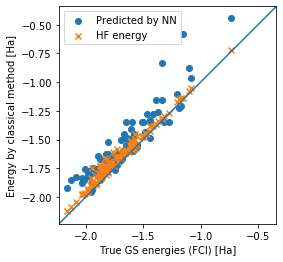

In [38]:
model = build_model(layer_size=8)
early_stop_training(model, patience = 100)
benchmark_model(model)

## custom STRONGLY asymmetric loss 

In [33]:
alpha = 10
def custom_loss(target, predicted):
    return tf.reduce_mean(
        alpha * (tf.abs(predicted - target) - (predicted - target))
        + tf.square(predicted - target) 
    )

def build_model(layer_size = 8, depth = 2):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(layer_size, activation='relu',
                              input_shape=[len(train_norm_input[0])])
    ] + [
        tf.keras.layers.Dense(layer_size, activation='relu')
        for _ in range(depth - 1)
    ] + [
        tf.keras.layers.Dense(1)
    ])

    #optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      0.05,
      decay_steps=len(train_output)*10,
      decay_rate=1,
      staircase=False)
    optimizer = tf.keras.optimizers.Adam(lr_schedule)

    model.compile(loss=custom_loss,
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model


Epoch: 0, loss:3.5989,  mae:1.3991,  mse:3.2324,  val_loss:0.6273,  val_mae:0.7386,  val_mse:0.6273,  
....................................................................................................
Epoch: 100, loss:0.0822,  mae:0.2028,  mse:0.0536,  val_loss:0.0874,  val_mae:0.2622,  val_mse:0.0859,  
....................................................................................................
Epoch: 200, loss:0.0698,  mae:0.2166,  mse:0.0590,  val_loss:0.0619,  val_mae:0.2317,  val_mse:0.0608,  
....................................................................................................
Epoch: 300, loss:0.0337,  mae:0.1565,  mse:0.0304,  val_loss:0.0458,  val_mae:0.1860,  val_mse:0.0458,  
....................................................................................................
Epoch: 400, loss:0.0342,  mae:0.1617,  mse:0.0317,  val_loss:0.0860,  val_mae:0.1133,  val_mse:0.0201,  
........................................................................

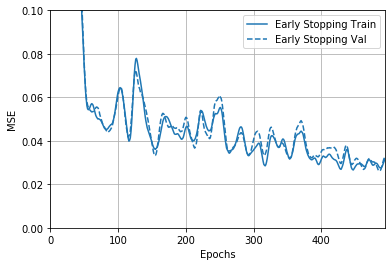

4/4 - 0s - loss: 0.0945 - mae: 0.1336 - mse: 0.0237
Test set Root Mean Square Error: 0.15 Ha
Hartree-Fock Root Mean Square Error: 0.07 Ha



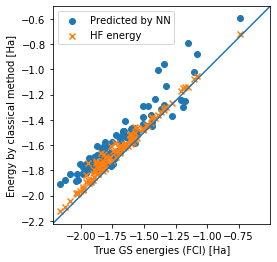

In [37]:
model = build_model(layer_size=8)
early_stop_training(model, patience = 100)
benchmark_model(model)

### conclusions:
Using an asymmetric loss function which penalizes energies below the exact energy can be useful if we don't want overshooting, at the cost of reducing the average accuracy in the final energy pediction.

**NOTE** the patience parameter of early_stop has to be increased in this case, as the training process is more erratic (we attribute this to the steeper loss function)